In [1]:
from pyspark.mllib.linalg import Matrices
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2017)

In this notebook, we'll implement the distributed version of the Affinity Propagation Clustering Algorithm.

In [56]:
def a(i, k, R, N):
    """
    This method computes the availability sent from point i to point k.

    Parameters
    ----------
    i : integer
            This is the index i needed to select the first point.

    k : integer
            This is the index k needed to select the first point.

    Returns
    -------
    a : float
            This is the availability of point i for k.
    """

    if i != k:
        a = min([0, R[k, k] + sum([max(0, R[i_prime, k]) for i_prime in range(N) if i_prime != i and i_prime != k])])
    else:
        a = sum([max(0, R[i_prime, k]) for i_prime in range(N) if i_prime != k])

    return a

def r(i, k, S, A, N):
    """
    This method computes the responsability sent from point i to point k.

    Parameters
    ----------
    i : integer
            This is the index i needed to select the first point.

    k : integer
            This is the index k needed to select the first point.

    Returns
    -------
    r : float
            This is the responsability of point i for k.
    """

    r = S[i, k] - max([A[i, k_prime] + S[i, k_prime] for k_prime in range(N) if k_prime != k])
    return r

def s(x_i, x_k):
    """
    This method computes the similarity between two points (negative squared error).

    Parameters
    ----------
    x_i : numpy array
            This is the ith point of the dataset.

    x_k : numpy array
            This is the kth point of the dataset.

    Returns
    -------
    s : float
            This is the similarity between points i and k.
    """

    s = -np.sum((x_i - x_k) ** 2)
    return s

def GenerateSimilarityMatrix(data, N):
    """
    This method generates the similarity matrix for all the points given to the mapper.

    Parameters
    ----------
    None

    Returns
    -------
    None
    """

    # Compute the similarity matrix # Make sure all items are return in the right order
    similarityMatrix = data.zipWithIndex().cartesian(data.zipWithIndex()).map(lambda X: (X[0][1], X[1][1], s(X[0][0], X[1][0])) if X[0][1] != X[1][1] else (X[0][1], X[1][1], 0.0))
    similarityMatrix = similarityMatrix.sortBy(lambda x: (x[0], x[1])).map(lambda y: y[2]).collect()
    S = Matrices.dense(N, N, similarityMatrix).toArray()

    # For diagonal: compute "preferences"
    flatS = S.flatten()
    med = np.median(flatS[flatS != 0.0])
    
    for i in range(N):
        S[i, i] = med
        
    return S

def ExecuteAffinityPropagation(data, A, R, N, iterations, lambdaValue = 0.5):
    """
    This method executes the Affinity Propagation algorithm on several iterations.

    Parameters
    ----------
    iterations : positive integer
            This is the number of iterations the algorithm will be executed.

    lambdaValue : float
            This is the lambda specified in the paper.

    Returns
    -------
    centers : list
            This list contains all the centroids computed by the algorithm.
    """

    # Compute the similarity matrix
    S = GenerateSimilarityMatrix(data, N)

    for it in range(iterations):
        print("iteration:", it)
        # Update r(i, k) given a(i, k)
        rMatrix = data.zipWithIndex().cartesian(data.zipWithIndex()).map(lambda X: (X[0][1], X[1][1], (1 - lambdaValue) * r(X[0][1], X[1][1], S, A, N) + lambdaValue * R[X[0][1], X[1][1]]))
        rMatrix = rMatrix.sortBy(lambda x: (x[0], x[1])).map(lambda y: y[2]).collect()
        R = Matrices.dense(N, N, rMatrix).toArray()
        
        # Update a(i, k) given r(i, k)        
        aMatrix = data.zipWithIndex().cartesian(data.zipWithIndex()).map(lambda X: (X[0][1], X[1][1], (1 - lambdaValue) * a(X[0][1], X[1][1], R, N) + lambdaValue * A[X[0][1], X[1][1]]))
        aMatrix = aMatrix.sortBy(lambda x: (x[0], x[1])).map(lambda y: y[2]).collect()
        A = Matrices.dense(N, N, aMatrix).toArray()

        # Combine both a(i, k) and r(i, k) to get centers
        centers = [i for i in range(N) if R[i, i] + A[i, i] > 0]

    return centers

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import Row

# Create a SparkSession # Only for Spark 2
spark = SparkSession.builder.appName("Affinity Propagation algorithm").getOrCreate()
    
# Read the data
irisData = spark.read.option("header","true").csv("iris_species.csv")

# Only keep useful columns
irisData = irisData.select("SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm")

# Make sure we've the right data type
irisData = irisData.withColumn("SepalLengthCm", irisData["SepalLengthCm"].cast("double"))
irisData = irisData.withColumn("SepalWidthCm", irisData["SepalWidthCm"].cast("double"))
irisData = irisData.withColumn("PetalLengthCm", irisData["PetalLengthCm"].cast("double"))
irisData = irisData.withColumn("PetalWidthCm", irisData["PetalWidthCm"].cast("double"))

splittedDataframe = irisData.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2]) # We do 5 splits with 20% data in each

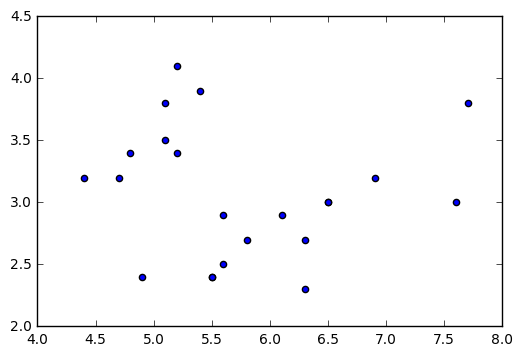

In [58]:
plotData = splittedDataframe[0].select("SepalLengthCm", "SepalWidthCm").toPandas()
plt.scatter(plotData["SepalLengthCm"], plotData["SepalWidthCm"])
plt.show()

In [59]:
# Reformat data to make possible the use of cartesian method
data = sc.parallelize(splittedDataframe[0].select("SepalLengthCm", "SepalWidthCm").rdd.map(lambda x: np.array([e for e in x])).collect())
    
# Number of samples in the dataset
N = splittedDataframe[0].count()

# Availabilities matrix
A = np.zeros((N, N))

# Responsabilities matrix
R = np.zeros((N, N))

centroids = ExecuteAffinityPropagation(data, A, R, N, 100)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

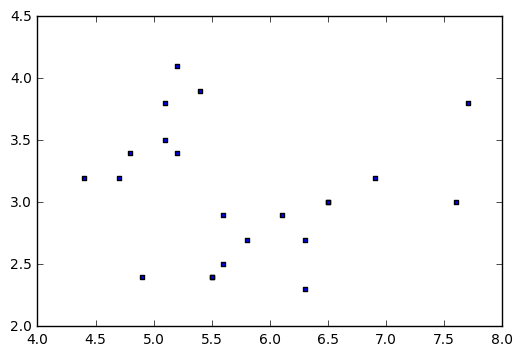

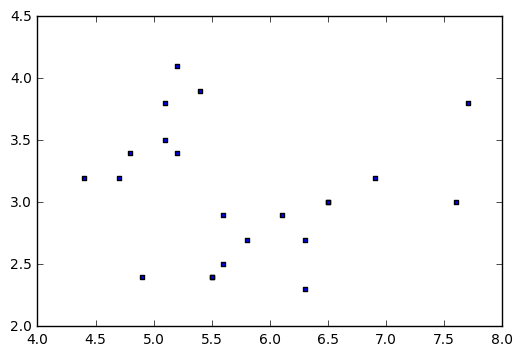

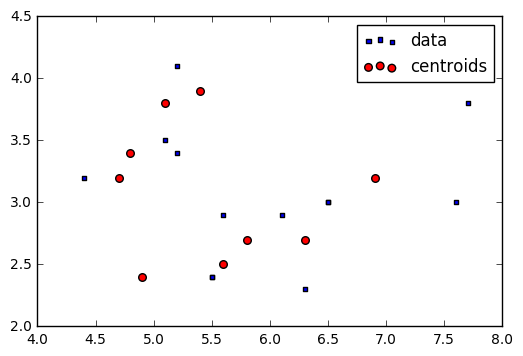

In [69]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(plotData["SepalLengthCm"], plotData["SepalWidthCm"], s = 10, c = 'b', marker = "s", label = 'data')
ax1.scatter(plotData.loc[plotData.index.isin(centroids), "SepalLengthCm"], plotData.loc[plotData.index.isin(centroids), "SepalWidthCm"], s = 30, c = 'r', marker = "o", label = 'centroids')
plt.legend(loc = 'upper right');
plt.show()